In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import numpy as np
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [2]:
methods = ["Postgres", "SafeBound"]
#benchmarks = ['JOBLight','JOBLightRanges', "JOBM", "Stats"]
benchmarks = ['JOBLight','JOBLightRanges', "Stats"]
runs = list(range(1,6))
inferenceResults = {method : {benchmark : dict() for benchmark in benchmarks} for method in methods}
rootFileDirectory = "/mnt/ExtraDrive1/SafeBound/Data/Results/"
for method in methods:
    for benchmark in benchmarks:
        for run in runs:
            querySize = pd.read_csv(rootFileDirectory + benchmark+"_Sizes.csv")
            resultFile = None
            if method == 'SafeBound':
                resultFile = rootFileDirectory + method + "_Inference_" + str(run) + "_" + benchmark + ".csv"
                if benchmark in []:
                    resultData = pd.DataFrame()
                    inferenceResults[method][benchmark][run] = resultData
                    continue
            elif method == 'Postgres':
                resultFile = rootFileDirectory + method + "_Inference_" +  str(run) + "_" + benchmark + ".csv"
                if benchmark in [""]:
                    resultData = pd.DataFrame()
                    inferenceResults[method][benchmark][run] = resultData
                    continue


            resultData = pd.read_csv(resultFile)
            resultData = resultData.merge(querySize, on='QueryLabel')
            resultData["JoinSize"] = resultData["JoinSize"].astype(float)
            resultData["Estimate"] =  resultData["Estimate"].astype(float)
            resultData["RelativeError"] = resultData["Estimate"]/resultData["JoinSize"]
            resultData["QError"] = np.maximum(resultData["RelativeError"], 1./resultData["RelativeError"])
            resultData["Benchmark"] = benchmark
            resultData["Method"] = method
            resultData["Run"] = run
            inferenceResults[method][benchmark][run] = resultData
            

In [3]:
allData = pd.concat([inferenceResults[method][benchmark][run] for method in methods for benchmark in benchmarks for run in runs])

In [4]:
p05Error = allData.groupby(['Method', 'Benchmark', 'Run']).quantile(.05)
p50Error = allData.groupby(['Method', 'Benchmark', 'Run']).quantile(.50)
p95Error = allData.groupby(['Method', 'Benchmark', 'Run']).quantile(.95)
topLineData = p05Error.join(p50Error["RelativeError"], lsuffix="p05",rsuffix="p50").join(p95Error["RelativeError"])
topLineData["RelativeErrorp95"] = topLineData["RelativeError"]
topLineData = topLineData.reset_index()

In [5]:
topLineData[((topLineData["Method"]=="SafeBound") & (topLineData["Run"]==4)) | ((topLineData["Method"]=="Postgres")& (topLineData["Run"]==2))| ((topLineData["Method"]=="Postgres2D")& (topLineData["Run"]==2))| ((~topLineData["Method"].isin(["Postgres", "SafeBound", "Postgres2D"])))].groupby(["Method", "Benchmark"]).mean()[['RelativeErrorp05','RelativeErrorp50','RelativeErrorp95']]

RelativeErrorp05  RelativeErrorp50  RelativeErrorp95
Method    Benchmark                                                           
Postgres  JOBLight                0.001410          0.112200          1.335873
          JOBLightRanges          0.000606          0.082373          2.874670
          Stats                   0.007681          1.041534        756.815354
SafeBound JOBLight                2.272742         21.401080       2507.835798
          JOBLightRanges          4.303409        159.153388      20626.212719
          Stats                   1.733568         55.347124       7775.377644

/tmp/ipykernel_288392/1640285409.py:38: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


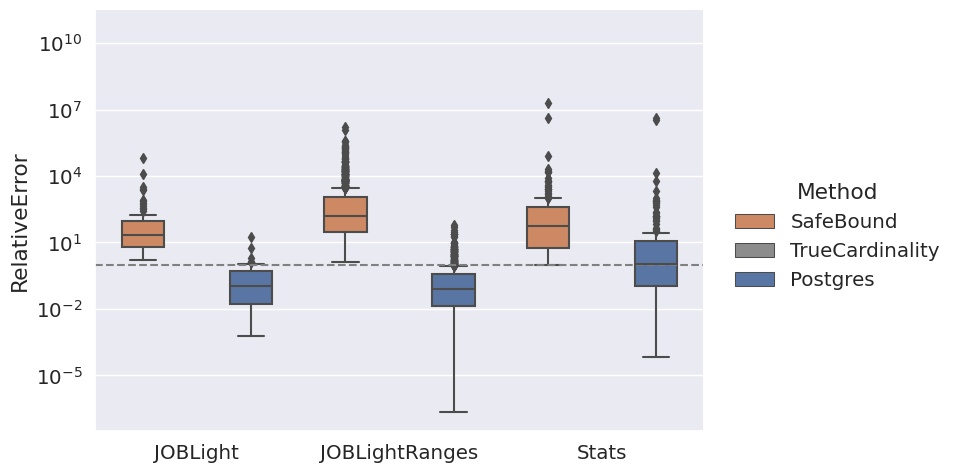

In [12]:
hueOrder =['SafeBound', "TrueCardinality", 'Postgres']
palette = ["C1", "C7", "C0", "C2", "C5", "C4", "C6"]
sn.set(font_scale = 1.3)
runData = allData[((allData["Method"]=='SafeBound')&(allData["Run"]==4))|((allData["Method"].isin(['Postgres']))&(allData["Run"]==2))]
inferencePlot = sn.catplot(x='Benchmark', y='RelativeError', hue='Method', kind='box', data=runData, height=5, aspect = 6/4, width=.8,palette=palette, hue_order=hueOrder)
inferencePlot.set(yscale='log', xlabel="", ylim=[10**-7.5, 10**11.5])
inferencePlot.map(plt.axhline, y=1, ls='--', c='grey')
adjust_box_widths(inferencePlot.figure, 0.8)